In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from UKMovementSensing import hsmm
from milleniumcohort import create_config

In [4]:
config = create_config('../config.yml')
config.create_data_paths()

In [5]:
import sqlite3
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

## Load data in database

In [6]:
config.model_path

'/media/sf_VBox_Shared/London//london_data_19Mei2017/results/mod_10st_0b_15r_720t_acceleration_anglex_angley_anglez'

In [7]:
# Import data with states
filenames = os.listdir(config.states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(config.states_path,fn))]

In [8]:
# Only do this if database is not filled yet!
fill_again = False
if(fill_again):
    c = conn.cursor()
    c.execute('drop table if exists data_with_states')
    for fn in filenames:
        dataset = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
        if len(dataset[dataset["state"].isnull()])>0 :
            print(fn)
        dataset.to_sql('data_with_states', conn, if_exists='append')


In [9]:
pd.read_sql('Select count(distinct filename), count(*) from data_with_states', conn)

,count(distinct filename),count(*)
0,1534,24278040


In [10]:
pd.read_sql('pragma table_info(data_with_states)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,timestamp,TIMESTAMP,0,None,0
1,1,acceleration,REAL,0,None,0
2,2,EN,REAL,0,None,0
3,3,anglex,REAL,0,None,0
4,4,angley,REAL,0,None,0
5,5,anglez,REAL,0,None,0
6,6,roll_med_acc_x,REAL,0,None,0
7,7,roll_med_acc_y,REAL,0,None,0
8,8,roll_med_acc_z,REAL,0,None,0
9,9,dev_roll_med_acc_x,REAL,0,None,0


## Preperation

In [11]:
states = pd.read_sql('Select distinct state from data_with_states', conn)

In [12]:
len(states)

10

In [13]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = 10 #len(states)
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [14]:
# Load simplified activities map
activities_simplified = pd.read_csv(config.activities_simplified_path, header=0, sep=',', dtype=str, encoding='utf-8')
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]
#activities_simplified.to_sql('activities_simplified', conn)

In [15]:

heuristic_classes = ['1 - no activity',  #1
                     '2 - inactivity', #2
                     '3 - light activity', #3 
                     '4 - vigorous activity', #4
                    '5 - MVPA at least 10 min', #5
                    '6 - MVPA 1-10 min', #6
                    '7 - inactivity at least 30min'] #7 
get_heuristic = lambda i: heuristic_classes[int(i)-1]

## Get subjects with >20 hour data

In [16]:
timecounts = pd.read_sql('Select filename, count(*) from data_with_states group by filename', conn)

In [17]:
timecounts = timecounts.set_index('filename')
timecounts.columns = ['cnt_5sec']
timecounts['cnt_hours'] = timecounts['cnt_5sec'] / (12.0 * 60)

In [18]:
#timecounts.to_sql('timecounts', conn)

In [19]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
longdays.shape

(974,)

## Calculate per-state statistics

In [23]:
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
query = '''Select state, ''' +  ','.join(['avg({})'.format(co) for co in numerical_columns]) + '''
from data_with_states group by state'''

avg_bystate = pd.read_sql(query, conn)

In [24]:
avg_bystate = avg_bystate.set_index('state').transpose()
avg_bystate.index = numerical_columns

In [25]:
means = avg_bystate.loc[config.hsmmconfig.column_names]
means.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3,4,5,6,7,8,9
acceleration,0.340202,4.94024e-06,0.0331302,0.0127453,0.0673963,0.0113924,0.134038,0.0070376,0.0151491,0.0147994
anglex,-3.38672,-6.17472,-31.2841,25.877,-41.4752,-48.107,-34.8088,-23.2412,-57.7811,29.9174
angley,4.31502,2.0068,-50.768,7.58666,19.657,15.9496,-34.949,36.7702,-7.37062,-6.97906
anglez,-4.4171,-8.68332,-4.78425,-36.0412,-2.52492,28.8715,11.1408,-35.0277,-24.3713,43.7228


In [26]:
avg_bystate.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3,4,5,6,7,8,9
acceleration,0.340202,4.94024e-06,0.0331302,0.0127453,0.0673963,0.0113924,0.134038,0.0070376,0.0151491,0.0147994
EN,1.29082,1.00453,1.01277,1.00296,1.02784,1.00051,1.07695,1.00107,1.00397,1.00414
anglex,-3.38672,-6.17472,-31.2841,25.877,-41.4752,-48.107,-34.8088,-23.2412,-57.7811,29.9174
angley,4.31502,2.0068,-50.768,7.58666,19.657,15.9496,-34.949,36.7702,-7.37062,-6.97906
anglez,-4.4171,-8.68332,-4.78425,-36.0412,-2.52492,28.8715,11.1408,-35.0277,-24.3713,43.7228
roll_med_acc_x,-0.0793144,-0.0930647,-0.466561,0.394436,-0.573899,-0.695224,-0.484027,-0.370171,-0.797383,0.4359
roll_med_acc_y,0.0794149,0.0347645,-0.711552,0.110462,0.277745,0.252796,-0.48746,0.538949,-0.123441,-0.106802
roll_med_acc_z,-0.0833684,-0.131141,-0.0770453,-0.526195,-0.0337777,0.448459,0.169852,-0.523774,-0.381948,0.618383
dev_roll_med_acc_x,-0.0188162,2.62293e-05,0.00130552,-0.00292935,0.00620241,0.0018971,-0.00477516,0.00110618,0.00449163,-0.0026666
dev_roll_med_acc_y,-0.0103751,7.27649e-06,0.00605039,6.88696e-05,-0.00591312,0.000128008,0.000238876,-0.00028718,0.00130342,0.000451532


In [27]:
#Create random sample to do calculations on
sample = pd.read_sql(
    '''select state, heuristic, acceleration, anglex, angley, anglez
        from data_with_states
        where abs(random()%1) < 0.1 
    ''', conn)

In [28]:
sample.shape

(24278040, 6)

In [29]:
sample = sample.dropna()

In [30]:
sample['cut-off'] = [get_heuristic(i) for i in sample['heuristic']]

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pandas/core/frame.py:5945: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


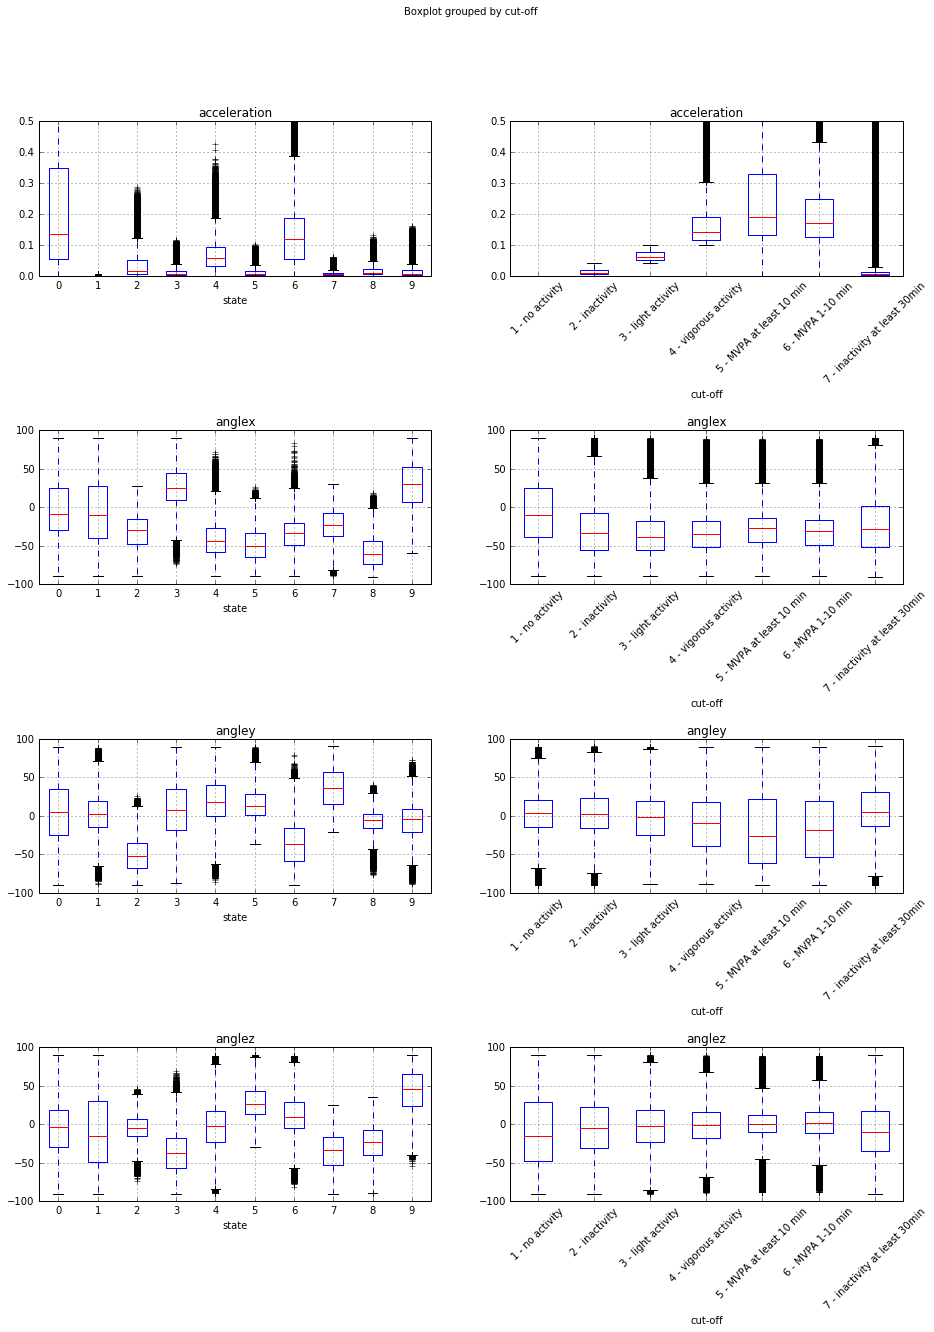

In [31]:
cols = ['acceleration', 'anglex', 'angley', 'anglez']
fig, axes = plt.subplots(len(cols), 2, figsize=(15, 20))
plt.subplots_adjust(hspace=1)
fig.set_label('')
sample.boxplot(by='state', column=cols, ax=axes[:,0])
sample.boxplot(by='cut-off', column=cols, ax=axes[:, 1], rot=45)
ymax_acc = 0.5
axes[0, 0].set_ylim(0, ymax_acc)
axes[0, 1].set_ylim(0, ymax_acc)
plt.savefig(os.path.join(config.image_path, 'boxplots.png'))

## Get sojourn times

In [20]:
data_sc = pd.read_sql('''select filename, subset, state, heuristic from data_with_states''', conn) 

In [21]:
data_sc['fn_s'] = data_sc['subset'].astype('str') + data_sc['filename']

In [22]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.fn_s.shift(1) != df.fn_s)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['fn_s'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'fn_s']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [23]:
sojourn_times_state = sojourn_times(data_sc, 'state')

In [24]:
sojourn_times_cutoff = sojourn_times(data_sc, 'heuristic')

In [25]:
sojourn_times_state['time_sec'] = sojourn_times_state['time']*5
sojourn_times_cutoff['time_sec'] = sojourn_times_cutoff['time']*5
sojourn_times_state['time_min'] = sojourn_times_state['time']/12.0
sojourn_times_cutoff['time_min'] = sojourn_times_cutoff['time']/12.0

In [26]:
sojourn_times_cutoff['cut-off'] = [get_heuristic(i) for i in sojourn_times_cutoff['heuristic']]

In [27]:
sojourn_times_cutoff.head()

,heuristic,time,time_sec,time_min,cut-off
0,1,1081,5405,90.083333,1 - no activity
1,1,74,370,6.166667,1 - no activity
2,1,501,2505,41.750000,1 - no activity
3,1,609,3045,50.750000,1 - no activity
4,1,295,1475,24.583333,1 - no activity


In [28]:
s_grouped = sojourn_times_state.groupby('state')['time_sec']
pd.concat((s_grouped.mean(), s_grouped.std(), s_grouped.max()), axis=1, keys=['mean', 'sigma', 'max'])

,mean,sigma,max
state,,,
0,10.903168,16.352145,985
1,608.421401,146.794150,1020
2,59.438164,36.644501,225
3,63.576718,36.794650,205
4,36.615930,22.002429,155
5,74.331463,45.406670,250
6,37.767687,21.940003,160
7,80.202765,47.349993,275
8,71.516887,43.530950,245


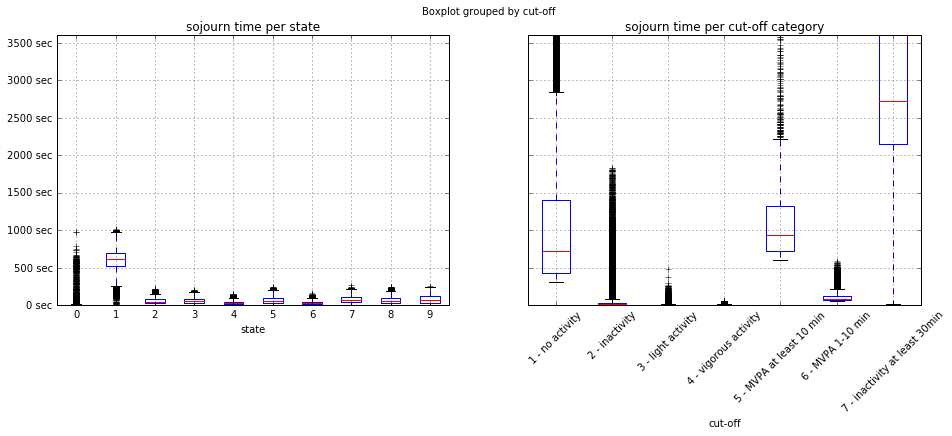

In [29]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 60*60
sojourn_times_state.boxplot(by='state', column='time_sec', ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-off', column='time_sec', ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-off category')
plt.savefig(os.path.join(config.image_path, 'sojourn.png'))
#plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [30]:
ctab_long = pd.read_sql('''select label, state, count(*) from data_with_states group by label, state''', conn) 

In [31]:
ctab = ctab_long.pivot(index='label', columns='state', values='count(*)')

In [32]:
activities_simplified

,Label,"Locomotion (no=0,yes=1,unclear=2)","Frequent arm angle changes (no=0,yes=1,unclear=2)",SUM,Keep variable,Behavioural category,simplified_category
0,Sleeping and resting (including sick in bed),0,0,0,TRUE,0,"low motion, low arm changes"
1,"Did nothing, just relaxing, bored, waiting",0,0,0,TRUE,0,"low motion, low arm changes"
2,"Watch TV, DVDs, downloaded videos",0,0,0,TRUE,0,"low motion, low arm changes"
3,Eating a meal,0,1,1,TRUE,1,"low motion, high arm changes"
4,Reading (not for school),0,1,1,TRUE,1,"low motion, high arm changes"
5,"Answering emails, instant messaging, texting",0,1,1,TRUE,1,"low motion, high arm changes"
6,"Travel by physically active means (walk, bike ...",1,1,2,TRUE,2,"high motion, high arm changes"
7,"Other exercise and sports, dancing, keeping fi...",1,1,2,TRUE,2,"high motion, high arm changes"
8,"Fixing things around the house, fixing bike, g...",1,1,2,TRUE,2,"high motion, high arm changes"
9,"Team ball games and training (e.g. football, h...",1,1,2,TRUE,2,"high motion, high arm changes"


In [33]:
ctab_merged = ctab_long.merge(activities_simplified, left_on='label', right_on='Label')
ctab_simplified_long = ctab_merged.groupby(['simplified_category', 'state'])[['count(*)']].sum()
ctab_simplified = ctab_simplified_long.reset_index().pivot(index='simplified_category', columns='state', values='count(*)')

In [34]:
ctab_simplified

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",131405,73667,192751,79683,333267,187997,294812,138140,195349,72429
"low motion, high arm changes",51134,97772,113636,87238,177327,179370,111877,151089,154573,64824
"low motion, low arm changes",209594,4313311,350229,612100,454245,600231,274381,787454,546200,482715
"low motion, mixed arm changes",202312,329089,474384,327892,804862,693865,472685,656192,803198,245881
"mixed motion, high arm changes",54326,133320,111592,74658,196788,141779,128043,118718,121340,62076
"mixed motion, low arm changes",8789,11133,20681,10870,47319,37117,24503,21632,35516,10200
"mixed motion, mixed arm changes",102560,151650,226416,138652,362077,301035,240272,213466,238542,118550


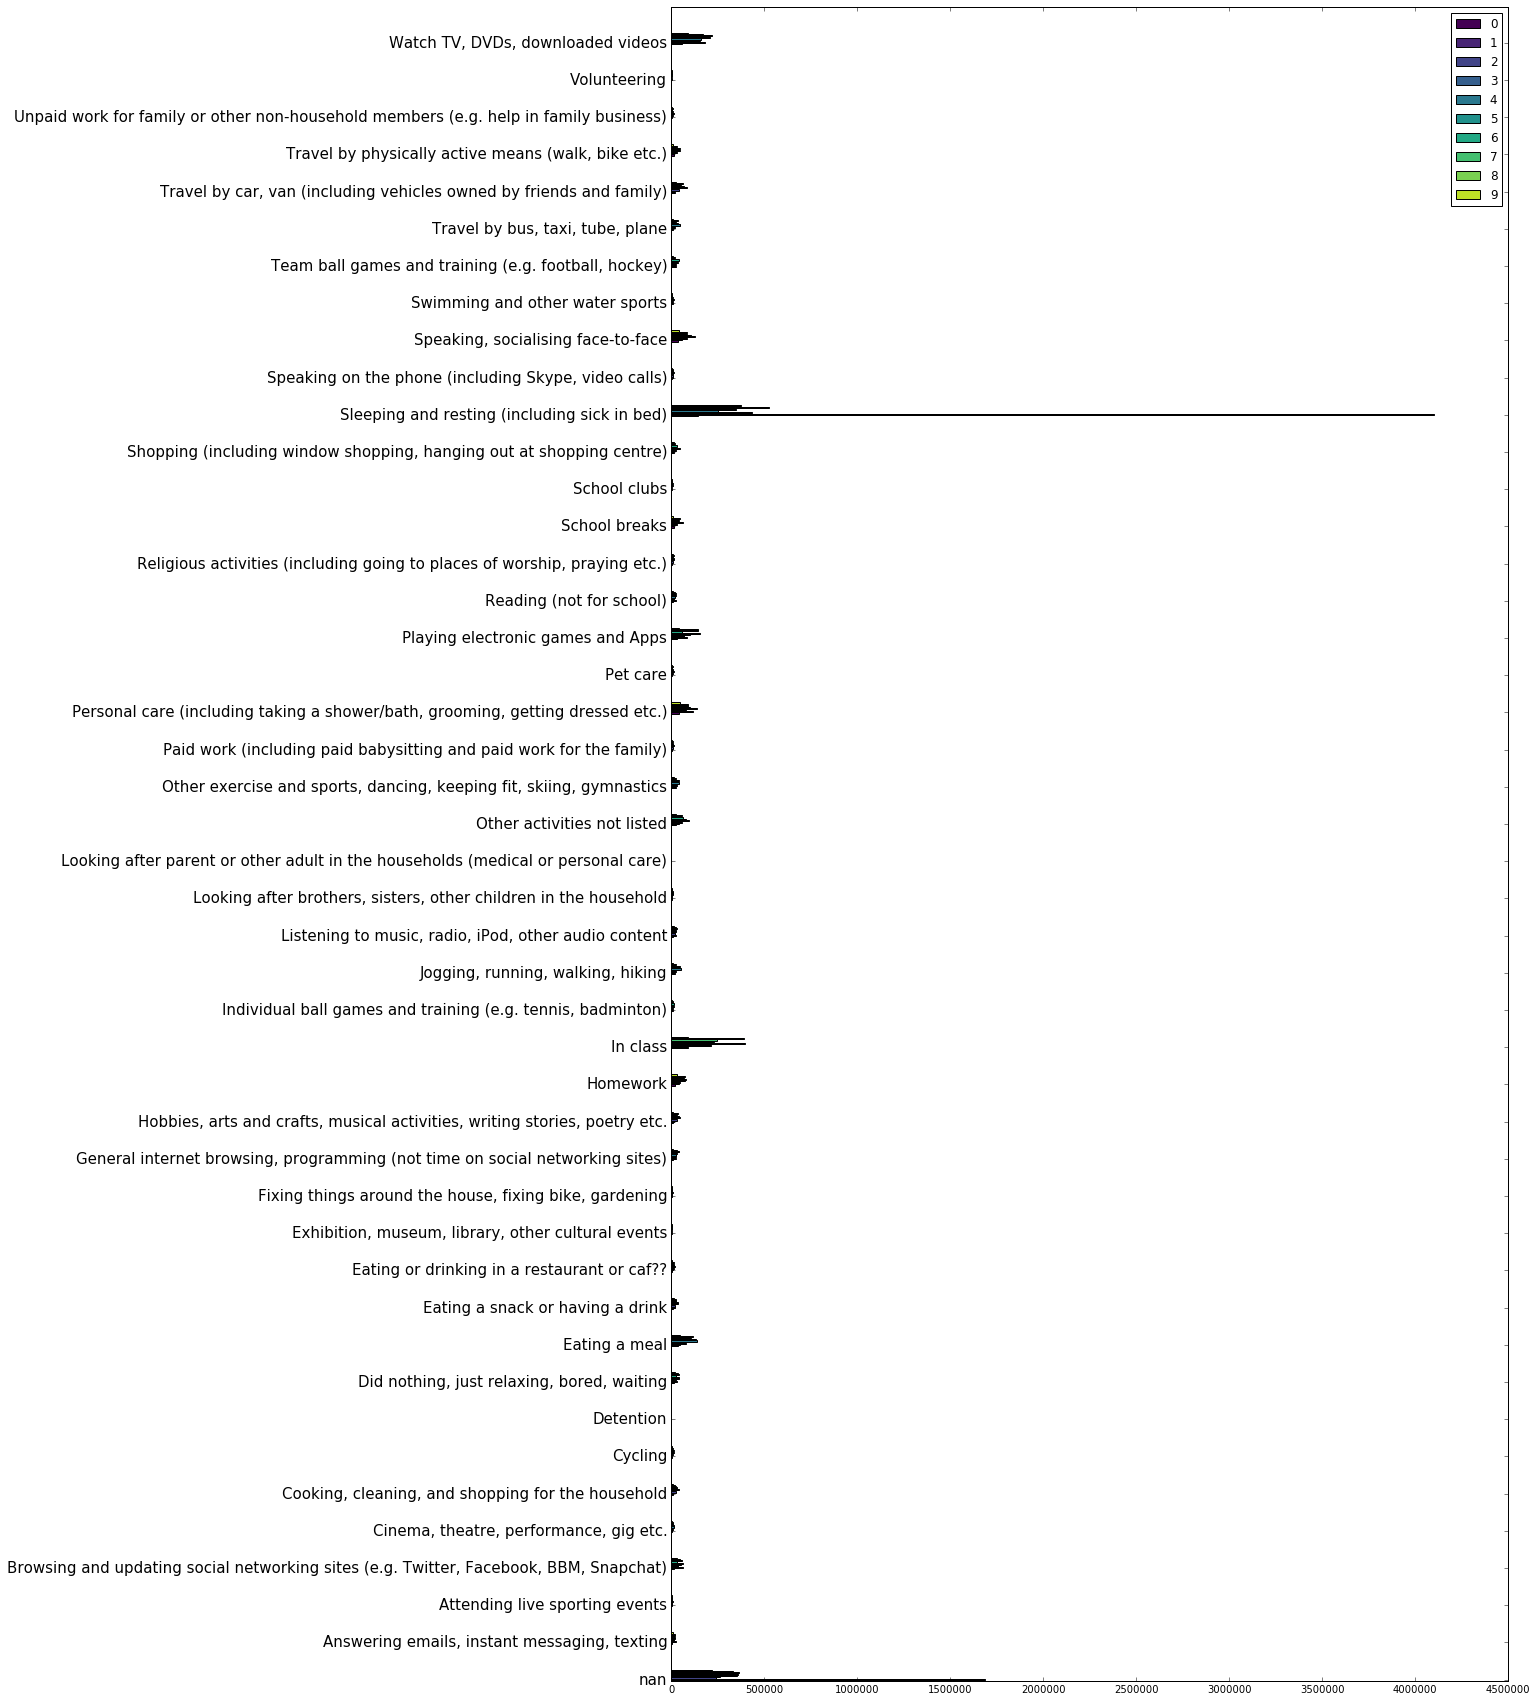

In [35]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [36]:
#Now normalize over the activity and sort by total number
ctab_norm1 = ctab_simplified.copy()
ctab_norm1.loc['All',:] = ctab_norm1.sum()
ctab_norm1 = ctab_norm1.divide(ctab_norm1.sum(axis=1), axis='index')

In [37]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",0.0773198,0.0433463,0.113416,0.0468861,0.196097,0.110619,0.17347,0.0812827,0.114945,0.0426178
"low motion, high arm changes",0.0430117,0.0822415,0.0955856,0.0733808,0.14916,0.150878,0.094106,0.127089,0.13002,0.0545271
"low motion, low arm changes",0.0242854,0.499778,0.0405806,0.0709232,0.0526328,0.069548,0.0317922,0.0912413,0.0632875,0.0559315
"low motion, mixed arm changes",0.0403787,0.0656817,0.0946806,0.0654428,0.16064,0.138486,0.0943415,0.130967,0.160307,0.0490745
"mixed motion, high arm changes",0.0475443,0.116677,0.0976616,0.0653382,0.172222,0.12408,0.112059,0.103898,0.106193,0.0543268
"mixed motion, low arm changes",0.0385889,0.0488804,0.0908017,0.0477257,0.207758,0.162965,0.107583,0.0949772,0.155936,0.044784
"mixed motion, mixed arm changes",0.0489963,0.0724482,0.108166,0.0662386,0.172976,0.143814,0.114786,0.10198,0.113959,0.0566352
All,0.0380197,0.255589,0.0745113,0.0665787,0.118837,0.107108,0.0773566,0.104372,0.104774,0.0528528


In [38]:
ctab_norm2 = ctab_simplified.copy()
ctab_norm2['All'] = ctab_norm2.sum(axis=1)
ctab_norm2.divide(ctab_norm2.sum(axis=0), axis='columns')

state,0,1,2,3,4,5,6,7,8,9,All
simplified_category,,,,,,,,,,,
"high motion, high arm changes",0.172874,0.014416,0.129390,0.059863,0.140271,0.087792,0.190623,0.066201,0.093258,0.068544,0.085006
"low motion, high arm changes",0.067271,0.019134,0.076282,0.065539,0.074636,0.083763,0.072339,0.072406,0.073792,0.061347,0.059463
"low motion, low arm changes",0.275738,0.844102,0.235102,0.459848,0.191190,0.280299,0.177412,0.377370,0.260751,0.456824,0.431679
"low motion, mixed arm changes",0.266158,0.064402,0.318445,0.246333,0.338763,0.324025,0.305634,0.314465,0.383440,0.232693,0.250608
"mixed motion, high arm changes",0.071470,0.026090,0.074910,0.056088,0.082827,0.066209,0.082791,0.056893,0.057927,0.058747,0.057153
"mixed motion, low arm changes",0.011563,0.002179,0.013883,0.008166,0.019916,0.017333,0.015843,0.010367,0.016955,0.009653,0.011392
"mixed motion, mixed arm changes",0.134926,0.029677,0.151989,0.104164,0.152397,0.140579,0.155358,0.102299,0.113878,0.112192,0.104699


In [39]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = ctab_simplified.copy()
ctab_norm2.loc['All'] = ctab_norm2.sum(axis=0)
ctab_norm2 = ctab_norm2.divide(ctab_norm2.sum(axis=1), axis='rows')

In [40]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",0.0773198,0.0433463,0.113416,0.0468861,0.196097,0.110619,0.17347,0.0812827,0.114945,0.0426178
"low motion, high arm changes",0.0430117,0.0822415,0.0955856,0.0733808,0.14916,0.150878,0.094106,0.127089,0.13002,0.0545271
"low motion, low arm changes",0.0242854,0.499778,0.0405806,0.0709232,0.0526328,0.069548,0.0317922,0.0912413,0.0632875,0.0559315
"low motion, mixed arm changes",0.0403787,0.0656817,0.0946806,0.0654428,0.16064,0.138486,0.0943415,0.130967,0.160307,0.0490745
"mixed motion, high arm changes",0.0475443,0.116677,0.0976616,0.0653382,0.172222,0.12408,0.112059,0.103898,0.106193,0.0543268
"mixed motion, low arm changes",0.0385889,0.0488804,0.0908017,0.0477257,0.207758,0.162965,0.107583,0.0949772,0.155936,0.044784
"mixed motion, mixed arm changes",0.0489963,0.0724482,0.108166,0.0662386,0.172976,0.143814,0.114786,0.10198,0.113959,0.0566352
All,0.0380197,0.255589,0.0745113,0.0665787,0.118837,0.107108,0.0773566,0.104372,0.104774,0.0528528


Check if there is a significant correlation between the states and the activities:

In [41]:
ctab['All'] = ctab.sum(axis=1)
ctab = ctab.sort_values('All', ascending=False)
ctab = ctab.fillna(0)

In [42]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

2290935.83655 0.0


In [43]:
ctab.head(10)

state,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
Sleeping and resting (including sick in bed),141304,4098053,210070,434638,250359,349948,156837,527017,340122,375152,6883500
NaN,132770,1689312,239104,261488,354407,357591,222951,361427,332686,219884,4171620
In class,88237,60459,211960,108046,393990,230948,226156,248248,388547,88989,2045580
"Watch TV, DVDs, downloaded videos",55089,183508,112783,155479,161358,207863,91730,220881,169476,89093,1447260
Playing electronic games and Apps,28575,87057,68019,66143,99045,153547,55154,145359,145312,41829,890040
Eating a meal,37905,47233,80329,60215,140237,134004,89865,104094,116831,45487,856200
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",40018,118229,79087,56873,139650,103325,87441,87960,90938,48299,851820
"Speaking, socialising face-to-face",38231,55886,83361,56543,125147,106990,84707,81443,82425,42227,756960
Other activities not listed,23441,41232,56067,31128,96647,77425,63318,49502,59577,27863,526200


In [44]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab[[a in activities for a in ctab.index]]

state,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
Sleeping and resting (including sick in bed),141304,4098053,210070,434638,250359,349948,156837,527017,340122,375152,6883500
"Jogging, running, walking, hiking",17406,10772,26381,10938,52728,29626,47290,19152,25108,8639,248040


## Compare with heuristic

In [45]:
ctab_heuristic_long = pd.read_sql('''select heuristic, state, count(*) from data_with_states group by heuristic, state''', conn)

In [46]:
ctab_heuristic = ctab_heuristic_long.pivot(index='heuristic', columns='state', values='count(*)').fillna(0)

In [47]:
ctab_heuristic.index = [get_heuristic(i) for i in ctab_heuristic.index]

In [48]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=0), axis=1)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,4,5,6,7,8,9
1 - no activity,0.0321128,0.987595,0.0559874,0.000945218,8.18443e-05,0.00798455,0.000584451,0.0790606,0.00807914,0.00123339
2 - inactivity,0.100866,0.00549648,0.412923,0.519531,0.275302,0.605823,0.146295,0.468313,0.585041,0.553097
3 - light activity,0.155436,0,0.218597,0.059413,0.393546,0.0319827,0.186456,0.00194927,0.0726226,0.0897771
4 - vigorous activity,0.244149,0,0.0586681,0.000115103,0.144646,0,0.243701,0,0.000255135,0.00391145
5 - MVPA at least 10 min,0.170572,0,0.0128862,0.000644325,0.033132,0.000434327,0.147241,0.000197163,0.000468089,0.00105641
6 - MVPA 1-10 min,0.171756,0,0.0123637,0.000131367,0.0488392,2.38641e-06,0.208817,2.84565e-06,0,0.000262739
7 - inactivity at least 30min,0.125108,0.00690806,0.228575,0.41922,0.104453,0.353773,0.0669062,0.450477,0.333534,0.350662


In [49]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=1), axis=0)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3,4,5,6,7,8,9
1 - no activity,0.00406861,0.94849,0.0137724,0.00021318,3.17441e-05,0.00283228,0.000147011,0.0274384,0.00278333,0.000223197
2 - inactivity,0.0120623,0.00498261,0.0958756,0.110597,0.100787,0.202839,0.0347334,0.15341,0.190241,0.0944729
3 - light activity,0.0579738,0,0.158298,0.0394464,0.449348,0.0333975,0.138066,0.00199151,0.0736517,0.0478261
4 - vigorous activity,0.18909,0,0.0882205,0.000158689,0.342948,0,0.374718,0,0.000537299,0.00432685
5 - MVPA at least 10 min,0.286663,0,0.0420477,0.00192759,0.170459,0.00204362,0.491277,0.000907652,0.00213906,0.00253581
6 - MVPA 1-10 min,0.225856,0,0.0315661,0.000307505,0.196605,8.78585e-06,0.545152,1.02502e-05,0,0.000493472
7 - inactivity at least 30min,0.0229458,0.00960417,0.0813954,0.136869,0.0586468,0.181661,0.0243622,0.226319,0.166337,0.0918598


## Heuristic vs states, per person

In [50]:
heuristic_states = pd.read_sql('''select d.filename, d.state, d.heuristic, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.heuristic;''', 
                               conn)

In [51]:
nr_subjects = len(heuristic_states['filename'].unique())
ctab = heuristic_states.groupby(['state', 'heuristic'])['count(*)'].sum()
ctab = ctab / nr_subjects
ctab = ctab.unstack(level=-1)
ctab = ctab.fillna(0)
ctab['total'] = heuristic_states.groupby(['state'])['count(*)'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab = ctab.applymap(lambda c: '{:.0f} min'.format(c/12.0))
ctab.columns = [get_heuristic(i) for i in ctab.columns[:-1]] + ['total']

In [52]:
ctab

,1 - no activity,2 - inactivity,3 - light activity,4 - vigorous activity,5 - MVPA at least 10 min,6 - MVPA 1-10 min,7 - inactivity at least 30min,total
state,,,,,,,,
0,2 min,5 min,8 min,12 min,9 min,9 min,6 min,50 min
1,417 min,2 min,0 min,0 min,0 min,0 min,2 min,421 min
2,4 min,41 min,22 min,6 min,1 min,1 min,20 min,95 min
3,0 min,49 min,5 min,0 min,0 min,0 min,38 min,92 min
4,0 min,44 min,63 min,23 min,5 min,8 min,17 min,159 min
5,1 min,88 min,5 min,0 min,0 min,0 min,51 min,145 min
6,0 min,15 min,19 min,25 min,15 min,21 min,7 min,101 min
7,11 min,68 min,0 min,0 min,0 min,0 min,62 min,142 min
8,1 min,83 min,10 min,0 min,0 min,0 min,47 min,142 min


## Distributions for the heuristic levels

## States for an example sequence

In [53]:
example_index = 674

In [54]:
fn = filenames[example_index]
data = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,...,filename,subset,switched_pos,binFile,day,activity,label,start_time,slot,state
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-04-14 03:45:00,0.000907,0.992121,13.719190,0.849393,76.253158,0.235546,0.014723,0.964731,0.000895,0.000463,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,9
2015-04-14 03:45:05,0.001425,0.993161,13.717265,0.667200,76.265882,0.235488,0.011564,0.964676,0.001772,0.001946,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,9
2015-04-14 03:45:10,0.001630,0.993256,13.712525,0.817176,76.261757,0.235468,0.014167,0.964906,0.001871,0.000237,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,9
2015-04-14 03:45:15,0.000901,0.991669,13.752782,0.669746,76.230277,0.235987,0.011603,0.964126,0.001275,0.001530,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,9
2015-04-14 03:45:20,0.001142,0.993087,13.727591,0.667884,76.255533,0.235720,0.011579,0.964873,0.001399,0.002274,...,__021694_2015-05-08 16-35-16.bin_day1.csv,0,True,__021694_2015-05-08 16-35-16.bin,1,NaN,NaN,NaN,NaN,9


In [55]:
hidden_states = data['state']

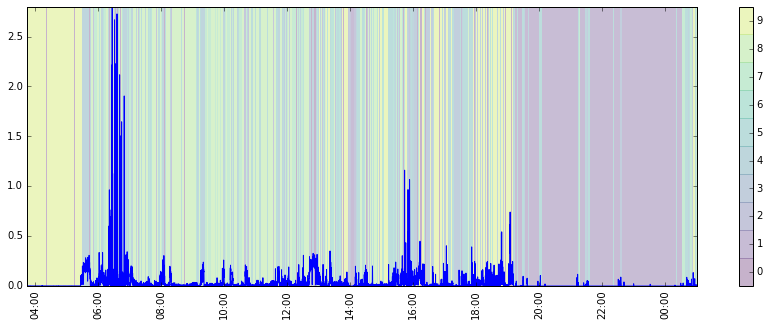

In [56]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration',], by='activity', cmap=cmap_states);
#plt.show()

(1440, 23)


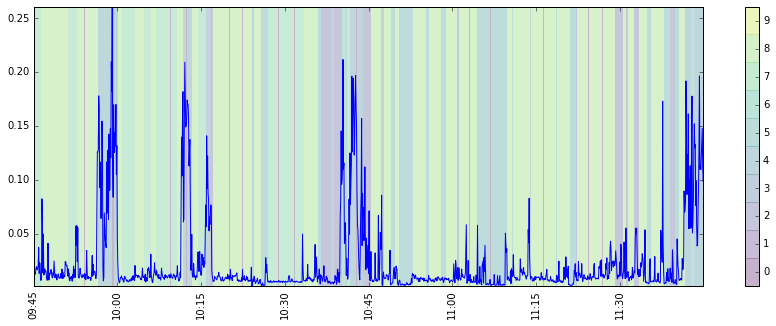

In [57]:
start =int(6*12*60)
end = 8*12*60
print(data[start:end].shape)
fig, ax = hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by=None)
ax.set_title('acceleration')

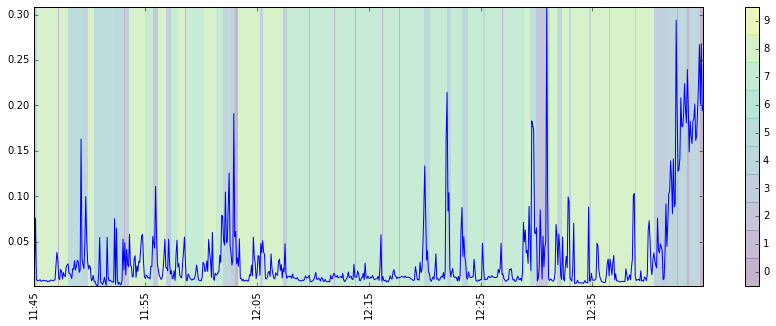

(<matplotlib.figure.Figure at 0x7f242796ac10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f24279b88d0>)

In [58]:
start =int(8*12*60)
end = 9*12*60
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='activity')

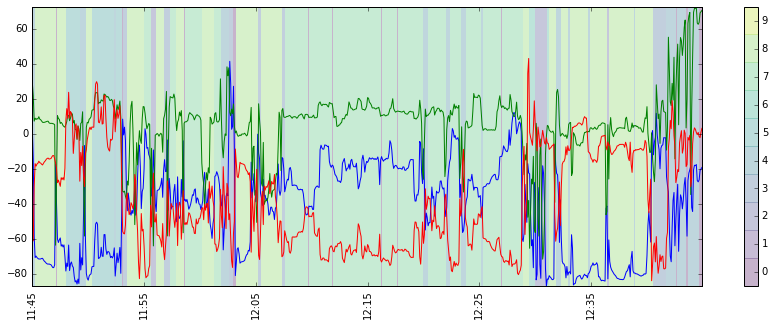

(<matplotlib.figure.Figure at 0x7f2422992d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2427923cd0>)

In [59]:
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='activity')